In [22]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import keras.backend as K
print(tf.__version__)

# Create a list with the filepaths for training and testing
train_dir = Path('custom_dataset/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg')) + list(train_dir.glob(r'**/*.jpeg')) 

test_dir = Path('custom_dataset/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.jpeg'))
val_dir = Path('custom_dataset/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.jpeg')) 

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

2.9.0


In [23]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2200

Number of different labels: 22

Labels: ['pizza' 'french_fries' 'chicken_curry' 'cauliflower' 'burger' 'tomato'
 'omlette' 'hot_dog' 'ice_cream' 'samosa' 'pineapple' 'banana' 'cheese'
 'cabbage' 'apple' 'grapes' 'mango' 'corn' 'momos' 'donuts' 'carrot'
 'soup']


In [24]:
train_df.head(5)

,Filepath,Label
0,custom_dataset\train\pizza\98617.jpg,pizza
1,custom_dataset\train\french_fries\164288.jpg,french_fries
2,custom_dataset\train\chicken_curry\54168.jpg,chicken_curry
3,custom_dataset\train\cauliflower\Image_5.JPG,cauliflower
4,custom_dataset\train\burger\5052.jpg,burger


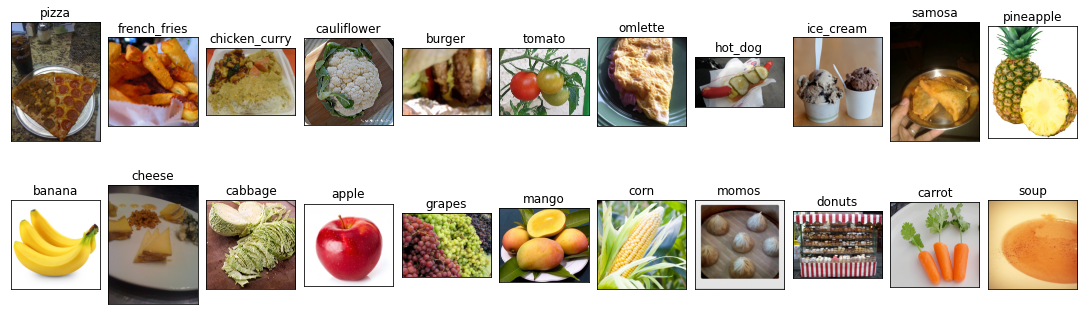

In [25]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=2, ncols=11, figsize=(15, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [26]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2200 validated image filenames belonging to 22 classes.
Found 221 validated image filenames belonging to 22 classes.
Found 219 validated image filenames belonging to 22 classes.


In [27]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [28]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(22, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
 6/69 [=>............................] - ETA: 1:48 - loss: 2.9409 - accuracy: 0.1615

C:\Users\Frank\miniconda3\envs\data-sci\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


69/69 [==============================] - 166s 2s/step - loss: 1.2445 - accuracy: 0.6577 - val_loss: 0.6057 - val_accuracy: 0.8281
Epoch 2/5
69/69 [==============================] - 130s 2s/step - loss: 0.3937 - accuracy: 0.8764 - val_loss: 0.4800 - val_accuracy: 0.8597
Epoch 3/5
69/69 [==============================] - 127s 2s/step - loss: 0.2061 - accuracy: 0.9427 - val_loss: 0.4101 - val_accuracy: 0.8733
Epoch 4/5
69/69 [==============================] - 124s 2s/step - loss: 0.1164 - accuracy: 0.9686 - val_loss: 0.3914 - val_accuracy: 0.8959
Epoch 5/5
69/69 [==============================] - 123s 2s/step - loss: 0.0578 - accuracy: 0.9923 - val_loss: 0.3879 - val_accuracy: 0.8824


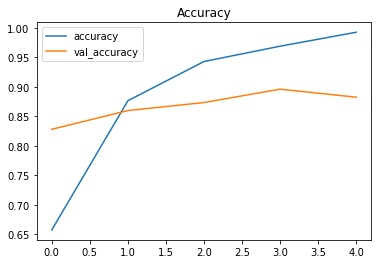

In [29]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

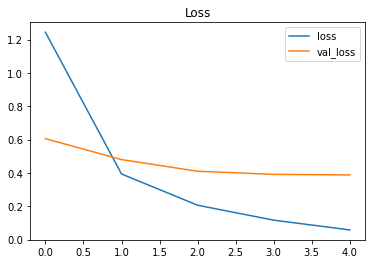

In [30]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [31]:
# Predict the Label of the testimages
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the Label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
y_test = [labels[k] for k in test_images.classes]
pred1

7/7 [==============================] - 16s 2s/step


['tomato',
 'grapes',
 'burger',
 'banana',
 'hot_dog',
 'burger',
 'cauliflower',
 'cabbage',
 'corn',
 'cauliflower',
 'grapes',
 'banana',
 'tomato',
 'chicken_curry',
 'pineapple',
 'donuts',
 'samosa',
 'pizza',
 'soup',
 'samosa',
 'grapes',
 'tomato',
 'cauliflower',
 'chicken_curry',
 'cauliflower',
 'burger',
 'apple',
 'ice_cream',
 'hot_dog',
 'pineapple',
 'burger',
 'french_fries',
 'burger',
 'french_fries',
 'pizza',
 'french_fries',
 'chicken_curry',
 'banana',
 'hot_dog',
 'carrot',
 'corn',
 'tomato',
 'omlette',
 'donuts',
 'mango',
 'chicken_curry',
 'mango',
 'chicken_curry',
 'momos',
 'momos',
 'soup',
 'banana',
 'omlette',
 'donuts',
 'ice_cream',
 'hot_dog',
 'apple',
 'apple',
 'soup',
 'cabbage',
 'chicken_curry',
 'corn',
 'french_fries',
 'soup',
 'carrot',
 'ice_cream',
 'grapes',
 'carrot',
 'banana',
 'hot_dog',
 'french_fries',
 'momos',
 'pizza',
 'samosa',
 'burger',
 'samosa',
 'cauliflower',
 'burger',
 'samosa',
 'soup',
 'mango',
 'momos',
 'omle

In [32]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred1)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 90.41%


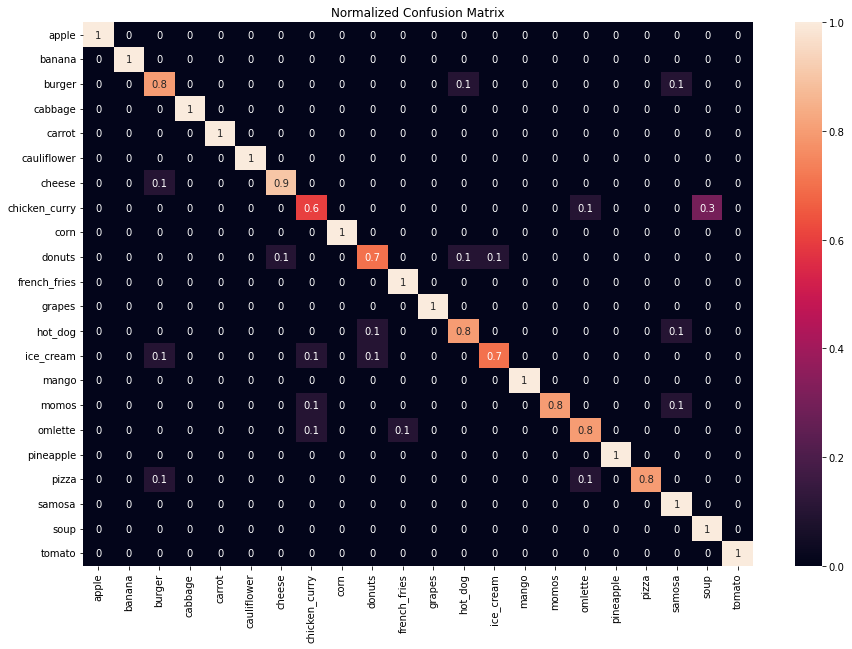

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred1, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

In [34]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [37]:
#testing with an image

img = output('custom_dataset/img/momo3.jpg')
img

1/1 [==============================] - 1s 748ms/step


'momos'

In [59]:
model.save('FV.h5')